In [171]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8")


In [172]:
def one_hot_encode(df, col):
    one_hot = pd.get_dummies(df[col])
    df.drop([col], axis=1, inplace=True)
    df = df.join(one_hot)
    
    return df

In [173]:
df = pd.read_csv("abalone.csv")
df = one_hot_encode(df, "Sex")
print(df.shape)
df.head()

(4177, 11)


,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings,F,I,M
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15,False,False,True
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7,False,False,True
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9,True,False,False
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10,False,False,True
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7,False,True,False


In [174]:
X, y = df.drop("Rings", axis=1), (df["Rings"] + 1.5).to_numpy()

scaler = MinMaxScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [182]:
device = "cuda" if torch.cuda.is_available() else "cpu"

class NeuralNetwork(nn.Module):
    
    def __init__(self, layer_sizes):
        super(NeuralNetwork, self).__init__()
        self.linears = nn.ModuleList(
            [nn.Linear(v, layer_sizes[i+1]) for i, v in enumerate(layer_sizes[:-1])]
        )
        
    def forward(self, x):
        for l in self.linears:
            x = F.relu(l(x))
            
        return x

Final loss = 4.617031097412109


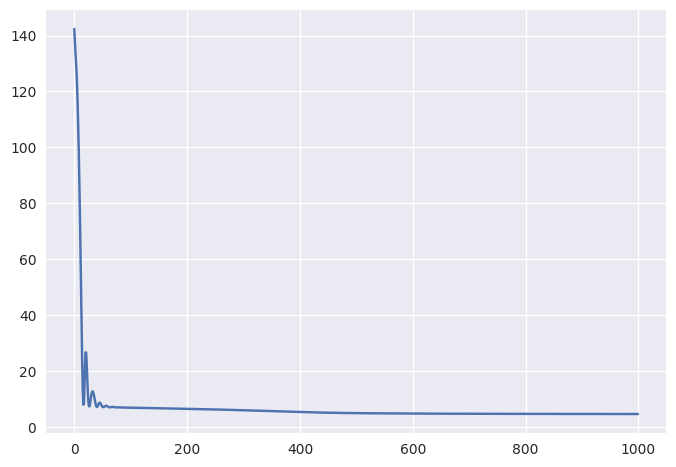

In [189]:
LEARNING_RATE = 0.05
NUM_EPOCHS = 1000

layers = [10, 5, 5, 1]
model = NeuralNetwork(layers).to(device)
criterion = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
losses = []

inputs = torch.from_numpy(X_train).to(torch.float32).to(device)
labels = torch.from_numpy(y_train.reshape(-1, 1)).to(torch.float32).to(device)


for epoch in range(NUM_EPOCHS):
    
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())

print(f"Final loss = {losses[-1]}")
plt.plot(range(NUM_EPOCHS), losses)
plt.show()

In [190]:
test_inputs = torch.from_numpy(X_test).to(torch.float32).to(device)
test_labels = torch.from_numpy(y_test)

with torch.no_grad():
    preds = model(test_inputs).cpu().detach().numpy()
    
r2_score(test_labels, preds)

0.5502070021547503